# Showcase of constrained optimization

This notebook demonstrates how ProcessOptimizer can provide suggestions for experiments that are forced to obey a sum constraint for some (or all) of its factors. This scenario is typically relevant when you work with mixtures, such as A + B + C must sum to 1.00 kg. For such a constraint to be meaningful, the factors that are part of the constraint must have the same units. Furthermore, with the present implementation of sum constraints it is also a requirement that the constrained factors are continuous numbers.

At present (March 2023) you can only draw initial experiments that obey these constraints. Drawing the best next experiment based on data, while obeying the constraints, is under development. Once complete, it will be added to this example.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.cm as mcolormap
from ProcessOptimizer import Optimizer
from ProcessOptimizer.plots import plot_objective, plot_objective_1d
from ProcessOptimizer.utils import expected_minimum
from ProcessOptimizer.space.constraints import Sum_equals

np.random.seed(42)

In [2]:
# Define a model system to use when wish to draw scores
noise = 0.1

# This model system is designed to operate on the space:
# [(-3.0, 3.0), (-3.0, 3.0), (-2.0, 2.0), (0, 2)]
def score(x, rng=np.random.default_rng(), noise_std=noise):
    y = (
        3*(1- x[0])**2 * np.exp(-x[0]**2 - (x[1]+1)**2)
        - 10*(x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-x[0]**2 - x[1]**2)
        - 1/3*np.exp(-(x[0]+1)**2 - x[1]**2)
    )
    return y + rng.normal(scale=noise_std)

In [3]:
# Build a space for experimentation
dimensions = [(0.0, 10.0), (0.0, 10.0), (0.0, 10.0), (0, 2)]
labels = ["Factor A", "Factor B", "Factor C", "Factor D"]

# Define constraint for this system in the form of having A, B and C sum to a
# total of some value we pick, and D can vary freely between its limits
constraints = [Sum_equals(dimensions=[0, 1, 2], value=5)]

# Build optimizer
opt = Optimizer(
    dimensions,
    lhs=False,
    acq_func="EI",
    n_initial_points=50,
    random_state=42,
    acq_func_kwargs={'xi':0.1},
)

# Apply our desired constraint before we ask for experiment suggestions
opt.set_constraints(constraints)
# Get first 50 points that respect the constraints A + B + C = 5
next_x_5 = opt.ask(50)

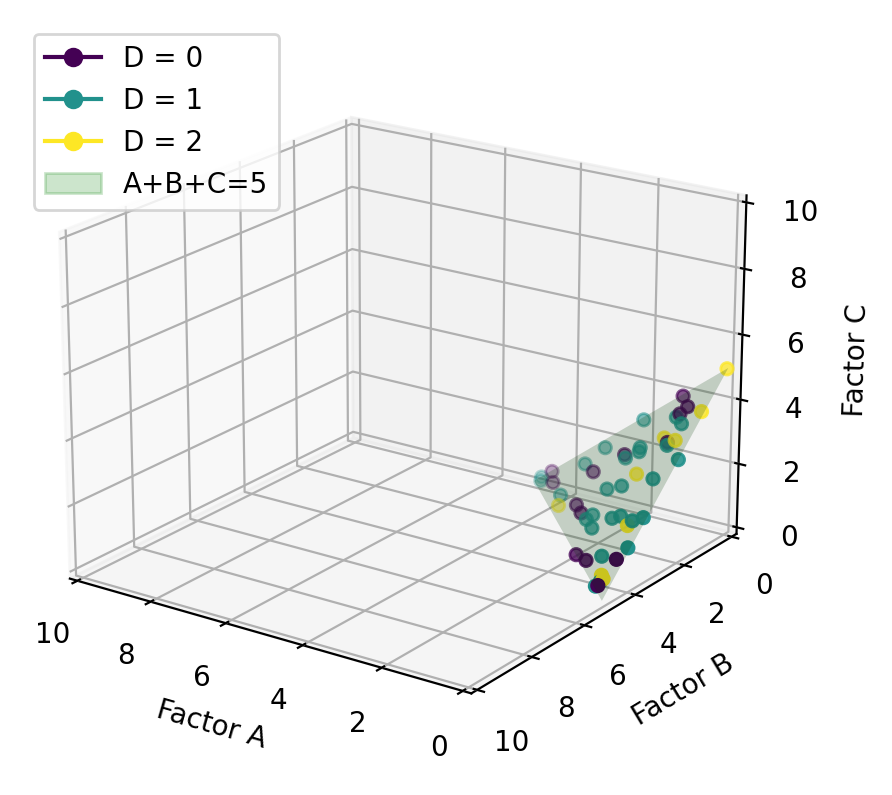

In [4]:
# Show the suggest experiment locations in the constrained factors
samples = np.array(next_x_5)
fig = plt.figure(figsize=(5, 5), dpi=200, facecolor="w")
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=125)
ax.scatter(samples[:,0], samples[:,1], samples[:,2], c=samples[:,3])

# Cosmetics
ax.set(
    xlabel=labels[0],
    ylabel=labels[1],
    zlabel=labels[2],
    xlim=(opt.space.bounds[0][0],opt.space.bounds[0][1]),
    ylim=(opt.space.bounds[1][0],opt.space.bounds[1][1]),
    zlim=(opt.space.bounds[2][0],opt.space.bounds[2][1]),
)
# Add a plane showing the constraint clearly
xx = np.array([0, 0, constraints[0].value])
yy = np.array([0, constraints[0].value, 0])
zz = np.array([constraints[0].value, 0, 0])
ax.plot_trisurf(xx, yy, zz, color="green", alpha=0.2)

# Add a legend
cmap = mcolormap.get_cmap('viridis')
D0_icon = mlines.Line2D([], [], color=cmap(0), marker="o", label="D = 0")
D1_icon = mlines.Line2D([], [], color=cmap(0.5), marker="o", label="D = 1")
D2_icon = mlines.Line2D([], [], color=cmap(1.0), marker="o", label="D = 2")
constraint_patch = mpatches.Patch(color="green", alpha=0.2, label="A+B+C={}".format(constraints[0].value))
ax.legend(handles=[D0_icon, D1_icon, D2_icon, constraint_patch], loc="upper left")
fig.savefig("Constraint_example_1.png")

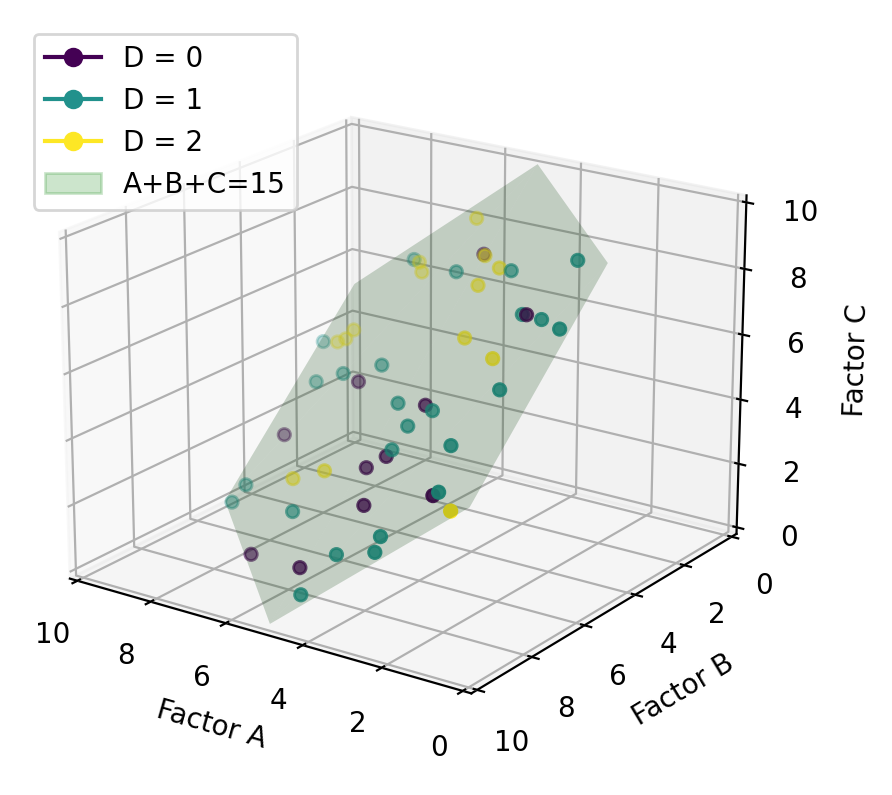

In [5]:
# Set a new constraint for a second plot example
constraints = [Sum_equals(dimensions=[0, 1, 2], value=15)]
# Apply our desired constraint before we ask for experiment suggestions
opt.set_constraints(constraints)
# Get first 50 points that respect the constraints A + B + C = 15
next_x_15 = opt.ask(50)

samples = np.array(next_x_15)
fig = plt.figure(figsize=(5, 5), dpi=200, facecolor="w")
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=20, azim=125)
ax.scatter(samples[:,0], samples[:,1], samples[:,2], c=samples[:,3])

# Cosmetics
ax.set(
    xlabel=labels[0],
    ylabel=labels[1],
    zlabel=labels[2],
    xlim=(opt.space.bounds[0][0],opt.space.bounds[0][1]),
    ylim=(opt.space.bounds[1][0],opt.space.bounds[1][1]),
    zlim=(opt.space.bounds[2][0],opt.space.bounds[2][1]),
)
# Add a plane showing the constraint clearly
xx = [10, 10, 5, 5, 0, 0]
yy = [0, 5, 10, 0, 5, 10]
zz = [5, 0, 0, 10, 10, 5]
ax.plot_trisurf(xx, yy, zz, color="green", alpha=0.2)

# Add a legend
cmap = mcolormap.get_cmap('viridis')
D0_icon = mlines.Line2D([], [], color=cmap(0), marker="o", label="D = 0")
D1_icon = mlines.Line2D([], [], color=cmap(0.5), marker="o", label="D = 1")
D2_icon = mlines.Line2D([], [], color=cmap(1.0), marker="o", label="D = 2")
constraint_patch = mpatches.Patch(color="green", alpha=0.2, label="A+B+C={}".format(constraints[0].value))
ax.legend(handles=[D0_icon, D1_icon, D2_icon, constraint_patch], loc="upper left")
fig.savefig("Constraint_example_2.png")

Next we will feed the optimizer with some data, and ask it for a new experiment that still obeys the constraints.